### Image Reconstruction Using AutoEncoder

### Import Section

In [1]:
import numpy as np
import cv2
import pandas as pd
import os
import tarfile
import tqdm
import ipywidgets

### Variable Definitions

In [2]:
ATTRS_NAME = "lfw_attributes.txt"

IMAGES_NAME = "lfw-deepfunneled.tgz"

RAW_IMAGES_NAME = "lfw.tgz"

### Decoding image from raw bytes

Here we use two functions: 

1. Convert raw matrix to image
2. Change color system to RGB

In [3]:
def decode_image_from_raw_bytes(raw_bytes):
  img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

### Loading the LFW dataset and adapting to the format using above function

In [4]:
def load_lfw_dataset(use_raw=False, dx=80, dy=80, dimx=45, dimy=45):
    # Reading the attributes from file
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Reading images
    all_images = []
    image_ids = []

    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_images.append(img)
                    image_ids.append({'person': person_id, 'imagenum': photo_number})

    image_ids = pd.DataFrame(image_ids)
    all_images = np.stack(all_images).astype('uint8')

    # Preserve image_ids order
    all_attrs = image_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_images, all_attrs

### Creating Autencoder Architecture

In [5]:
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

/tmp/ipykernel_66348/1358090373.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(f.getmembers()):


  0%|          | 0/18983 [00:00<?, ?it/s]

In [6]:
X = X.astype('float32') / 255.0 - 0.5

In [7]:
print(X.max(), X.min())

0.5 -0.5


In [8]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

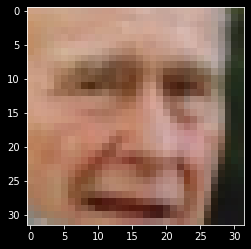

In [9]:
show_image(X[6])

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [11]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

2022-11-28 22:25:52.669023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/devangm/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-28 22:25:52.669068: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [12]:
# Same as (32,32,3), we neglect the number of instances from shape
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

2022-11-28 22:26:16.536995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/devangm/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-28 22:26:16.537027: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-28 22:26:16.537078: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-11-28 22:26:16.537287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32)                98336     
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         101376    
                                                                 
Total params: 199,712
Trainable params: 199,712
Non-trainable params: 0
_________________________________________________________________
None


### Model Trading

In [13]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=20, validation_data=[X_test, X_test])

2022-11-28 22:26:17.756297: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 145342464 exceeds 10% of free system memory.
2022-11-28 22:26:17.897920: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 145342464 exceeds 10% of free system memory.


Epoch 1/20
370/370 [==============================] - 4s 8ms/step - loss: 0.0146 - val_loss: 0.0104
Epoch 2/20
370/370 [==============================] - 2s 6ms/step - loss: 0.0093 - val_loss: 0.0082
Epoch 3/20
370/370 [==============================] - 2s 6ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 4/20
370/370 [==============================] - 2s 6ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 5/20
370/370 [==============================] - 2s 6ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 6/20
370/370 [==============================] - 2s 6ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 7/20
370/370 [==============================] - 2s 6ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 8/20
370/370 [==============================] - 2s 6ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 9/20
370/370 [==============================] - 2s 6ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
370/370 [==============================] - 2s 6ms/step - loss: 0.0066 - val_loss: 0.0066

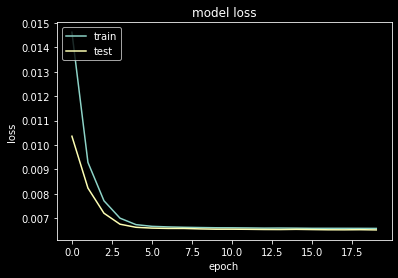

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Visualization

1/1 [==============================] - 0s 50ms/step


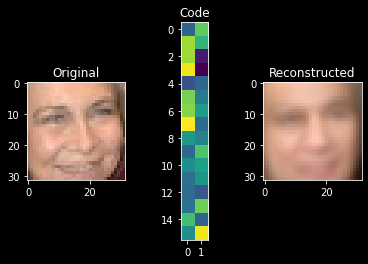

1/1 [==============================] - 0s 28ms/step


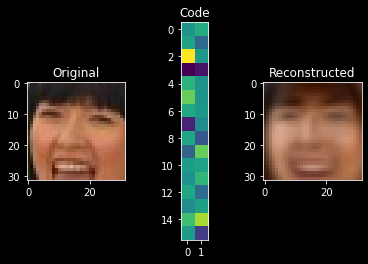

1/1 [==============================] - 0s 18ms/step


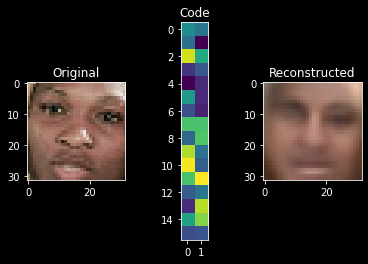

1/1 [==============================] - 0s 31ms/step


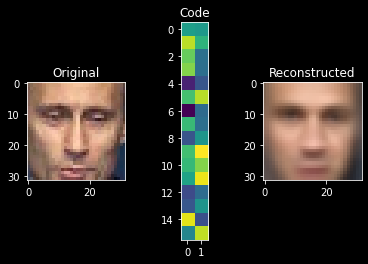

1/1 [==============================] - 0s 24ms/step


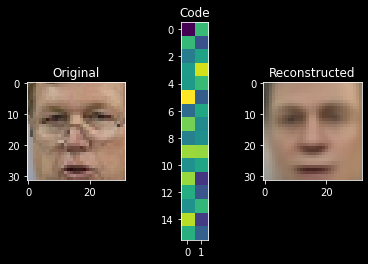

In [15]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

### Image Denoising

In [16]:
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

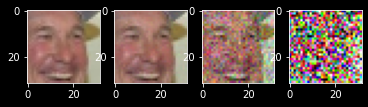

In [17]:
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

In [18]:
code_size = 100

# We can use bigger code size for better quality
encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=code_size)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(5):
    print("Epoch %i/5, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    # We continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=2,
                    validation_data=[X_test_noise, X_test])

Epoch 1/5, Generating corrupted samples...
Epoch 1/2


2022-11-28 22:27:14.782381: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 145342464 exceeds 10% of free system memory.
2022-11-28 22:27:14.914734: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 145342464 exceeds 10% of free system memory.


370/370 [==============================] - 5s 12ms/step - loss: 0.0132 - val_loss: 0.0087
Epoch 2/2
370/370 [==============================] - 4s 11ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 2/5, Generating corrupted samples...
Epoch 1/2
  6/370 [..............................] - ETA: 4s - loss: 0.0063

2022-11-28 22:27:28.681081: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 145342464 exceeds 10% of free system memory.


370/370 [==============================] - 4s 11ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 2/2
370/370 [==============================] - 4s 12ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 3/5, Generating corrupted samples...
Epoch 1/2
370/370 [==============================] - 4s 12ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 2/2
370/370 [==============================] - 4s 12ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 4/5, Generating corrupted samples...
Epoch 1/2
370/370 [==============================] - 4s 11ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 2/2
370/370 [==============================] - 4s 12ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 5/5, Generating corrupted samples...
Epoch 1/2
370/370 [==============================] - 4s 12ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 2/2
370/370 [==============================] - 4s 11ms/step - loss: 0.0037 - val_loss: 0.0037


1/1 [==============================] - 1s 690ms/step


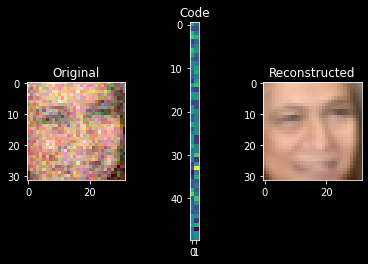

1/1 [==============================] - 0s 23ms/step


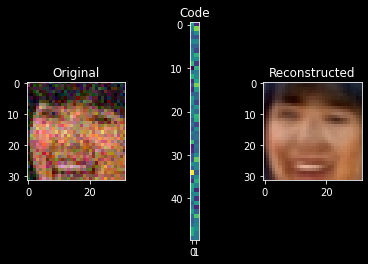

1/1 [==============================] - 0s 31ms/step


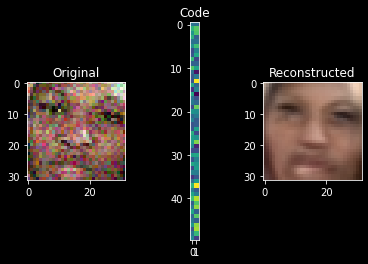

1/1 [==============================] - 0s 27ms/step


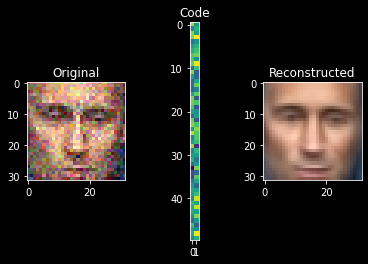

1/1 [==============================] - 0s 26ms/step


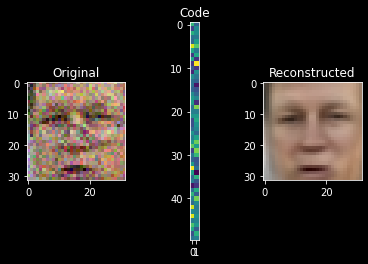

In [19]:
X_test_noise = apply_gaussian_noise(X_test)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)